In [21]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import TweedieRegressor
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

In [22]:
df = pd.read_csv('../Data/experience_2009_derived.csv')

# Clean total_pmpm_2009
df['total_pmpm_2009'] = (
    df['total_pmpm_2009']
    .astype(str)
    .str.replace(',', '', regex=False)
    .str.replace('$', '', regex=False)
    .str.strip()
)

df['total_pmpm_2009'] = pd.to_numeric(df['total_pmpm_2009'], errors='coerce')

# Several pmpms are negative
df['total_pmpm_2009'] = df['total_pmpm_2009'].clip(lower=0)

# Sex binary
df['female'] = (df['sex_code'] == 2).astype(int)

# Create age bands
df['age_band'] = pd.cut(
    df['age_2009'],
    bins=[0, 40, 60, 80, 120],
    labels=['21-40', '41-60', '61-80', '81+']
)

# Create Inpatient Count feature. Cap count to prevent extreme counts from distorting model
df['ip_count_capped'] = df['inpatient_claims_count_2009'].clip(upper=3)

# Create Outpatient Visit bands
df['op_band'] = pd.cut(
    df['outpatient_claims_count_2009'],
    bins=[-1, 0, 2, 5, 100],
    labels=['0', '1-2', '3-5', '6+']
)

# Create Carrier Intensity quartiles
df['carrier_band'] = pd.qcut(df['carrier_claims_count_2009'], q=4, labels=False)

# Create interaction terms
df['ip_x_81plus'] = df['any_inpatient_2009'] * (df['age_band'] == '81+').astype(int)
df['rx_x_age'] = df['any_rx_2009'] * df['age_2009']


In [23]:
y = df['total_pmpm_2009']

X = df[
    [
        'female',
        'any_inpatient_2009',
        'ip_count_capped',
        'any_rx_2009',
        'ip_x_81plus',
        'rx_x_age',
        'age_band',
        'op_band',
        'carrier_band'
    ]
]

X = pd.get_dummies(X, drop_first=True)


In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=10
)


In [25]:
glm = TweedieRegressor(
    power=1.5,
    link='log',
    alpha=0.001,
    max_iter=1000
)

# Train the model
glm.fit(X_train, y_train)


,"power power: float, default=0The power determines the underlying target distribution accordingto the following table:+-------+------------------------+| Power | Distribution |+=======+========================+| 0 | Normal |+-------+------------------------+| 1 | Poisson |+-------+------------------------+| (1,2) | Compound Poisson Gamma |+-------+------------------------+| 2 | Gamma |+-------+------------------------+| 3 | Inverse Gaussian |+-------+------------------------+For ``0 < power < 1``, no distribution exists.",1.5
,"alpha alpha: float, default=1Constant that multiplies the L2 penalty term and determines theregularization strength. ``alpha = 0`` is equivalent to unpenalizedGLMs. In this case, the design matrix `X` must have full column rank(no collinearities).Values of `alpha` must be in the range `[0.0, inf)`.",0.001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the linear predictor (`X @ coef + intercept`).",True
,"link link: {'auto', 'identity', 'log'}, default='auto'The link function of the GLM, i.e. mapping from linear predictor`X @ coeff + intercept` to prediction `y_pred`. Option 'auto' setsthe link depending on the chosen `power` parameter as follows:- 'identity' for ``power <= 0``, e.g. for the Normal distribution- 'log' for ``power > 0``, e.g. for Poisson, Gamma and Inverse Gaussian distributions",'log'
,"solver solver: {'lbfgs', 'newton-cholesky'}, default='lbfgs'Algorithm to use in the optimization problem:'lbfgs' Calls scipy's L-BFGS-B optimizer.'newton-cholesky' Uses Newton-Raphson steps (in arbitrary precision arithmetic equivalent to iterated reweighted least squares) with an inner Cholesky based solver. This solver is a good choice for `n_samples` >> `n_features`, especially with one-hot encoded categorical features with rare categories. Be aware that the memory usage of this solver has a quadratic dependency on `n_features` because it explicitly computes the Hessian matrix. .. versionadded:: 1.2",'lbfgs'
,"max_iter max_iter: int, default=100The maximal number of iterations for the solver.Values must be in the range `[1, inf)`.",1000
,"tol tol: float, default=1e-4Stopping criterion. For the lbfgs solver,the iteration will stop when ``max{|g_j|, j = 1, ..., d} <= tol``where ``g_j`` is the j-th component of the gradient (derivative) ofthe objective function.Values must be in the range `(0.0, inf)`.",0.0001
,"warm_start warm_start: bool, default=FalseIf set to ``True``, reuse the solution of the previous call to ``fit``as initialization for ``coef_`` and ``intercept_`` .",False
,"verbose verbose: int, default=0For the lbfgs solver set verbose to any positive number for verbosity.Values must be in the range `[0, inf)`.",0


In [26]:
# Make predictions on test data
pred_test = glm.predict(X_test)

# Calculate errors for validation
rmse = np.sqrt(mean_squared_error(y_test, pred_test))

print(f'Test RMSE: ${rmse:,.2f}')
print(f'Mean Actual: ${y_test.mean():,.2f}')
print(f'Mean Predicted: ${pred_test.mean():,.2f}')


Test RMSE: $493.09
Mean Actual: $504.89
Mean Predicted: $514.20


In [27]:
# Create a table comparing the average actual cost with the average predicted cost, separated by decile
# Admit rate displayed to show importance of inpatient admission driving cost

results = X_test.copy()
results['actual'] = y_test
results['predicted'] = pred_test

results['any_ip'] = df.loc[results.index, 'any_inpatient_2009']

results['decile'] = pd.qcut(results['predicted'], 10, labels=False)

dec_table = results.groupby('decile').agg(
    avg_actual=('actual', 'mean'),
    avg_pred=('predicted', 'mean'),
    admit_rate=('any_ip', 'mean'),
    total_cost=('actual', 'sum')
)

dec_table.insert(2, 'ratio', dec_table['avg_actual'] / dec_table['avg_pred'])

print(dec_table)


         avg_actual     avg_pred     ratio  admit_rate  total_cost
decile                                                            
0          0.346805    45.309155  0.007654    0.000000     1230.81
1         96.899127    86.369222  1.121917    0.000000   323061.69
2        126.921903   108.133259  1.173755    0.000000   435595.97
3        176.678501   165.923164  1.064821    0.002033   608304.08
4        230.128868   226.640390  1.015392    0.006969   792563.82
5        346.708098   313.103818  1.107326    0.026209  1190595.61
6        434.115026   401.549878  1.081099    0.037566  1490751.00
7        610.205432   565.402730  1.079240    0.097646  2099716.89
8       1038.934878   855.217106  1.214820    0.504368  3567702.37
9       1992.062823  2376.259935  0.838319    1.000000  6850704.05


In [28]:
# Create a table showing the percent of the total cost captured by top deciles.
# For example, output shows that top 30% (decile 7 and up) account for 72.1% of the total cost
cost_table = results.groupby('decile')['actual'].sum().sort_index(ascending=False)
cost_table = cost_table.cumsum() / cost_table.sum()
print(cost_table)


decile
9    0.394621
8    0.600131
7    0.721081
6    0.806952
5    0.875534
4    0.921188
3    0.956228
2    0.981320
1    0.999929
0    1.000000
Name: actual, dtype: float64


In [29]:
# DataFrome displays the features and their coefficients, with relativity showing the importance of each feature

coef_table = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': glm.coef_,
})

coef_table['Relativity'] = np.exp(coef_table['Coefficient'])
coef_table = coef_table.sort_values('Relativity', ascending=False)

coef_table.style.hide()


Feature,Coefficient,Relativity
any_rx_2009,1.061950,2.892006
any_inpatient_2009,0.887414,2.428840
op_band_6+,0.648558,1.912780
carrier_band,0.457172,1.579601
op_band_3-5,0.441705,1.555357
ip_count_capped,0.355050,1.426252
op_band_1-2,0.330146,1.391171
age_band_81+,0.270097,1.310092
age_band_61-80,0.139398,1.149581
age_band_41-60,0.097246,1.102131


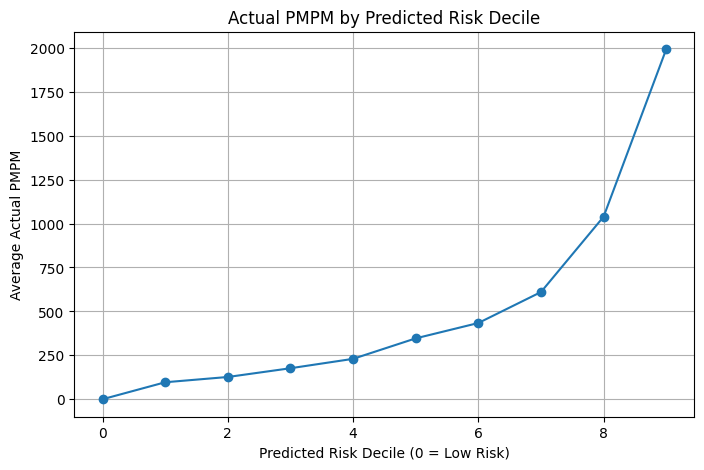

In [30]:
# 'Actual PMPM by Predicted Risk Decile' plots the actual average PMPM for the test data,
# with costs separated based on which cost decile the model estimated it to fall into.
# As expected, the higher deciles have higher actual average costs.

plt.figure(figsize=(8,5))
plt.plot(dec_table['avg_actual'], marker='o')
plt.title("Actual PMPM by Predicted Risk Decile")
plt.xlabel("Predicted Risk Decile (0 = Low Risk)")
plt.ylabel("Average Actual PMPM")
plt.grid(True)
plt.show()


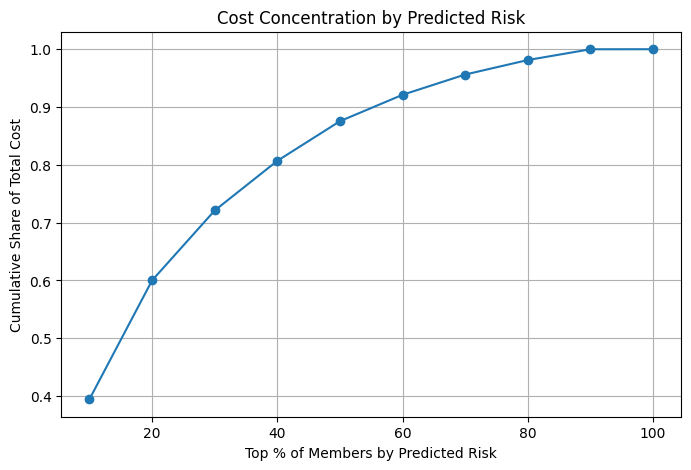

In [31]:
# 'Cost Concentration by Predicted Risk' plots the relationship between each decile and the total share of the cost.
# For example, the plot shows that the top 20% of members account for 60% of the cost.

dec_table['cost_share'] = dec_table['total_cost'] / dec_table['total_cost'].sum()
dec_table = dec_table.sort_values('decile', ascending=False)
dec_table['cum_cost_share'] = dec_table['cost_share'].cumsum()
dec_table['top_pct_members'] = np.arange(1, 11) * 10

plt.figure(figsize=(8,5))
plt.plot(dec_table['top_pct_members'],
         dec_table['cum_cost_share'],
         marker='o')

plt.xlabel("Top % of Members by Predicted Risk")
plt.ylabel("Cumulative Share of Total Cost")
plt.title("Cost Concentration by Predicted Risk")
plt.grid(True)
plt.show()
